<a href="https://colab.research.google.com/github/kcarvajalb/TrabajoPractico/blob/main/KarenTrabajoPractico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico** <br>
**Nombre:** Karen Patricia Carvajal Barreto <br>


**Fuente de datos:**

Los datos provienen de la página Inside Airbnb. Esta página contiene datos trimestrales del último año para cada región. Los datos obtenidos provienen de la sección de “Washington, D.C., District of Columbia, United States”, el archivo obtenido se llama “listings.csv.gz”, el cual contiene la lista detallada de las propiedades.

Enlace principal: http://insideairbnb.com/get-the-data/

Dataset descargado para la actividad:
http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/data/listings.csv.gz


Datos de georreferenciación: http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/visualisations/neighbourhoods.geojson

# **Análisis de precios para alquiler de alojamientos en la plataforma Airbnb en la ciudad de Washington D.C.**

Instalamos la librería para graficar mapas e importamos los módulos

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.7 MB/s 
     |████████████████████████████████| 16.7 MB 25.0 MB/s 
     |████████████████████████████████| 6.3 MB 33.2 MB/s 


In [2]:
import pandas as pd
import io
import requests
from io import BytesIO
from urllib.request import Request, urlopen
import gzip
import seaborn as sns
import timeit
import matplotlib.pyplot as plt
from google.colab import files

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

Descargamos los datos del repositorio de la página de [inside airbnb](http://insideairbnb.com/get-the-data/). 

In [3]:
url = "http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/data/listings.csv.gz"
req = Request(url)
req.add_header('Accept-Encoding', 'gzip')
response = urlopen(req)
content = gzip.decompress(response.read())
datos_all=pd.read_csv(io.StringIO(content.decode('utf-8')))

Borrado de características nulas, vacias o consideradas irrelevantes para este ejercicio, por lo tanto, las características elegindas del dataset son:

In [4]:
caracteristicas_finales = ['host_id', 'host_acceptance_rate', 'host_listings_count','host_identity_verified', 'neighbourhood_cleansed', 'latitude','longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price','minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'has_availability', 'availability_365',
       'number_of_reviews', 'instant_bookable']

datos = datos_all[caracteristicas_finales].copy()
datos.columns

Index(['host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_365',
       'number_of_reviews', 'instant_bookable'],
      dtype='object')

Revisamos la forma del dataset, en este caso contiene 6473 observaciones y 75 características.

In [5]:
datos.shape

(6473, 23)

Revisión de valores faltantes:

In [6]:
datos.isnull().sum()

host_id                      0
host_acceptance_rate      1027
host_listings_count        161
host_identity_verified     161
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms_text               7
bedrooms                   633
beds                       147
amenities                    0
price                        0
minimum_nights               0
maximum_nights               0
minimum_nights_avg_ntm       1
maximum_nights_avg_ntm       1
has_availability             0
availability_365             0
number_of_reviews            0
instant_bookable             0
dtype: int64

Transformación del precio, eliminamos los caracteres $ y ,

Convertimos a entero:

In [7]:
# Eliminamos el caracter $ , del precio
datos['price'] = datos['price'].str.replace('$','').str.replace(',','')

# Convertimos a entero
datos['price'] = datos['price'].astype(float).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Definimos variable numérica para el tipo de habitación:

In [8]:
#Define una variable numérica: room_type_num
def room_type_num_func(row):
 room_type={'Private room':1,'Entire home/apt':2,'Shared room':3,'Hotel room':4}
 return room_type[row.room_type]

# Ejecutamos la función
datos['room_type_num'] = datos.apply(room_type_num_func, axis='columns')

Visualizamos los datos:

In [9]:
datos.head()

,host_id,host_acceptance_rate,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_365,number_of_reviews,instant_bookable,room_type_num
0,4645,100%,1.0,t,Historic Anacostia,38.863390,-76.988890,Private room in home,Private room,1,...,67,31,365,31.0,365.0,t,306,81,f,1
1,315148,48%,71.0,t,"Brightwood Park, Crestwood, Petworth",38.937190,-77.023350,Private room in rental unit,Private room,1,...,39,31,360,31.0,360.0,t,46,14,f,1
2,5059,76%,4.0,t,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.911950,-77.004560,Private room in townhouse,Private room,3,...,75,1,1125,1.0,1125.0,t,298,443,f,1
3,2236092,93%,4.0,t,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.898980,-77.016290,Entire condo,Entire home/apt,2,...,250,31,1125,31.0,1125.0,t,90,69,f,2
4,511136,100%,4.0,t,"Dupont Circle, Connecticut Avenue/K Street",38.907833,-77.045673,Private room in guest suite,Private room,3,...,113,1,30,1.1,47.0,t,134,464,f,1


Obtenemos los datos de los vecindarios en formato geojson para graficar el mapa

In [10]:
def definir_color(feature):
    value = valores_precio.get(feature['properties']['neighbourhood'])
    return color(value)

datos_tmp = datos[["neighbourhood_cleansed","price"]].copy()
datos_tmp = datos_tmp.groupby(['neighbourhood_cleansed'], as_index=False)['price'].mean()
datos_tmp.rename(columns={'neighbourhood_cleansed': 'neighbourhood', 'price': 'Precio_Promedio'}, inplace=True)

datos_geojson = gpd.read_file("http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/visualisations/neighbourhoods.geojson")
datos_geojson = pd.merge(datos_geojson, datos_tmp, on='neighbourhood', how='left')
datos_geojson.drop("neighbourhood_group", axis = 1, inplace = True)
valores_precio = datos_geojson.set_index('neighbourhood')['Precio_Promedio'].to_dict()
color = LinearColormap(['yellow','red'], vmin = min(valores_precio.values()), vmax = max(valores_precio.values()))

In [11]:
fig = folium.Figure(width=800, height=650)
latitudes_dc = datos['latitude'].tolist()
longitudes_dc = datos['longitude'].tolist()
puntos_mapa = list(zip(latitudes_dc, longitudes_dc))

# le colocamos latitud y longitud de washington para que el mapa inicie ahi
mapa_airbnb = folium.Map(location=[38.91545, -77.0305], zoom_start = 12) 
FastMarkerCluster(data = puntos_mapa).add_to(mapa_airbnb)
title_html = """<h3 align="center" style="font-size:16px"><b>Mapa de alojamientos en la ciudad de Washington D.C</b></h3>"""
fig.get_root().html.add_child(folium.Element(title_html))
fig.add_child(mapa_airbnb)

In [12]:
fig = folium.Figure(width=800, height=650)
mapa_precios = folium.Map(location=[38.91545, -77.0305], zoom_start = 12) 
folium.GeoJson(data = datos_geojson, name='Washington D.C',
                tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'Precio_Promedio'],labels=True,sticky=False), style_function = lambda feature: {
                  'fillColor': definir_color(feature),'color': 'black','weight': 0.5,'dashArray': '3, 3','fillOpacity':0.7
                },
                highlight_function=lambda feature: {'weight': 4, 'fillColor': definir_color(feature), 'fillOpacity': 0.4}).add_to(mapa_precios)
title_html = """<h3 align="center" style="font-size:16px"><b>Mapa de precios de alojamientos en la ciudad de Washington D.C</b></h3>"""
fig.get_root().html.add_child(folium.Element(title_html))                
fig.add_child(mapa_precios)


Mapa de correlación:

Text(0.5, 1.0, 'Correlación de características del dataset de Airbnb en la ciudad de Washington D.C')

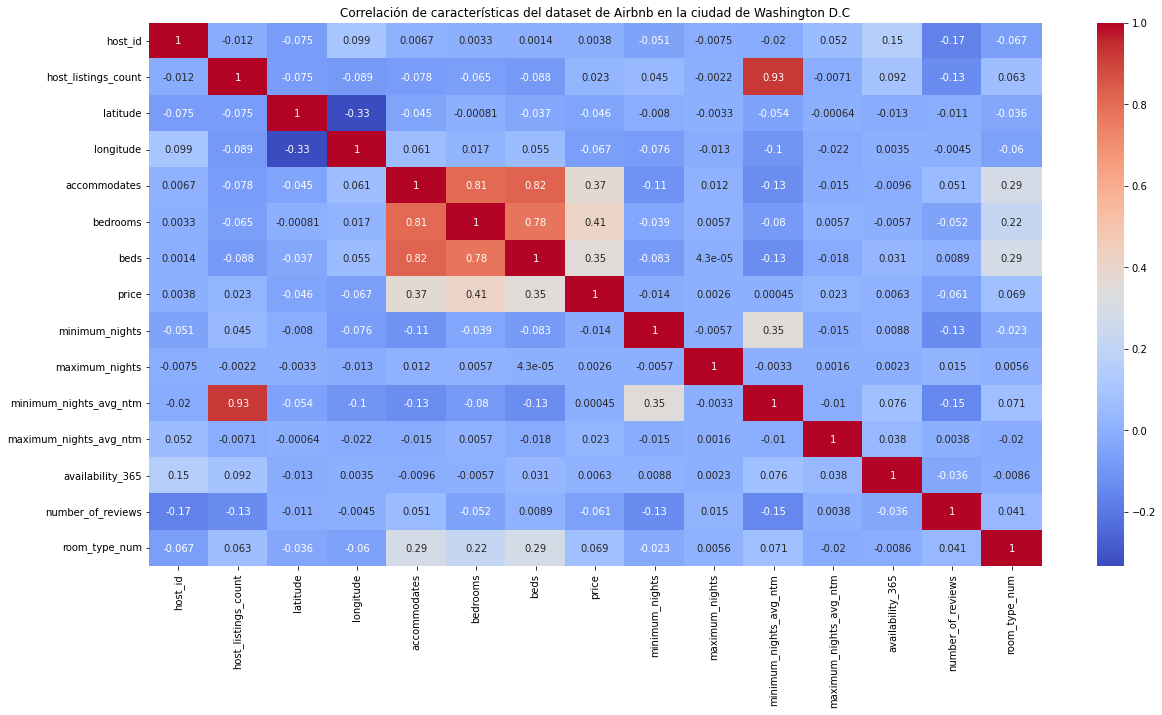

In [17]:
# dibujamos el mapa con las correlaciones de todas las variables
hfig, axes = plt.subplots(figsize=(20,10))  
sns.heatmap(datos.corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de características del dataset de Airbnb en la ciudad de Washington D.C')

In [13]:
#plt.scatter(x = datos["bedrooms"], y = datos["price"])

In [14]:
#ax = sns.countplot(x='bedrooms', hue='room_type', data=datos)

Para los alojamientos, graficamos el número de dormitorios:

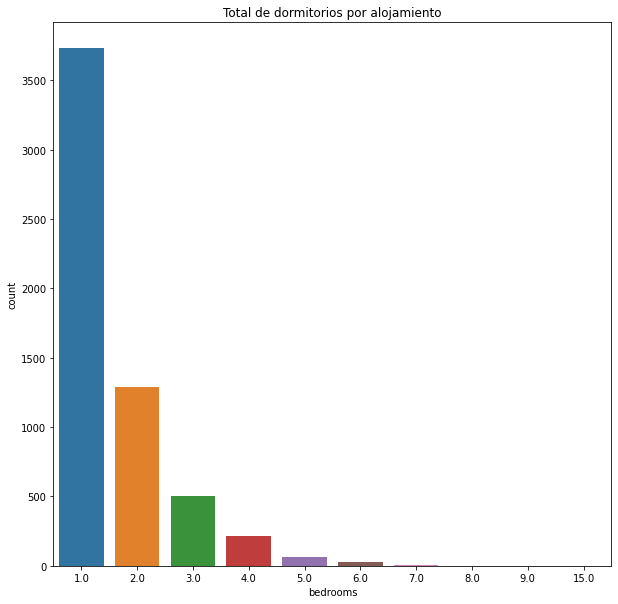

In [15]:
plt.figure(figsize=(10,10))
ax = sns.countplot(data=datos, x='bedrooms').set(title="Total de dormitorios por alojamiento")

Top 10 de barrios donde hay alojamientos:

Número de barrios únicos
39


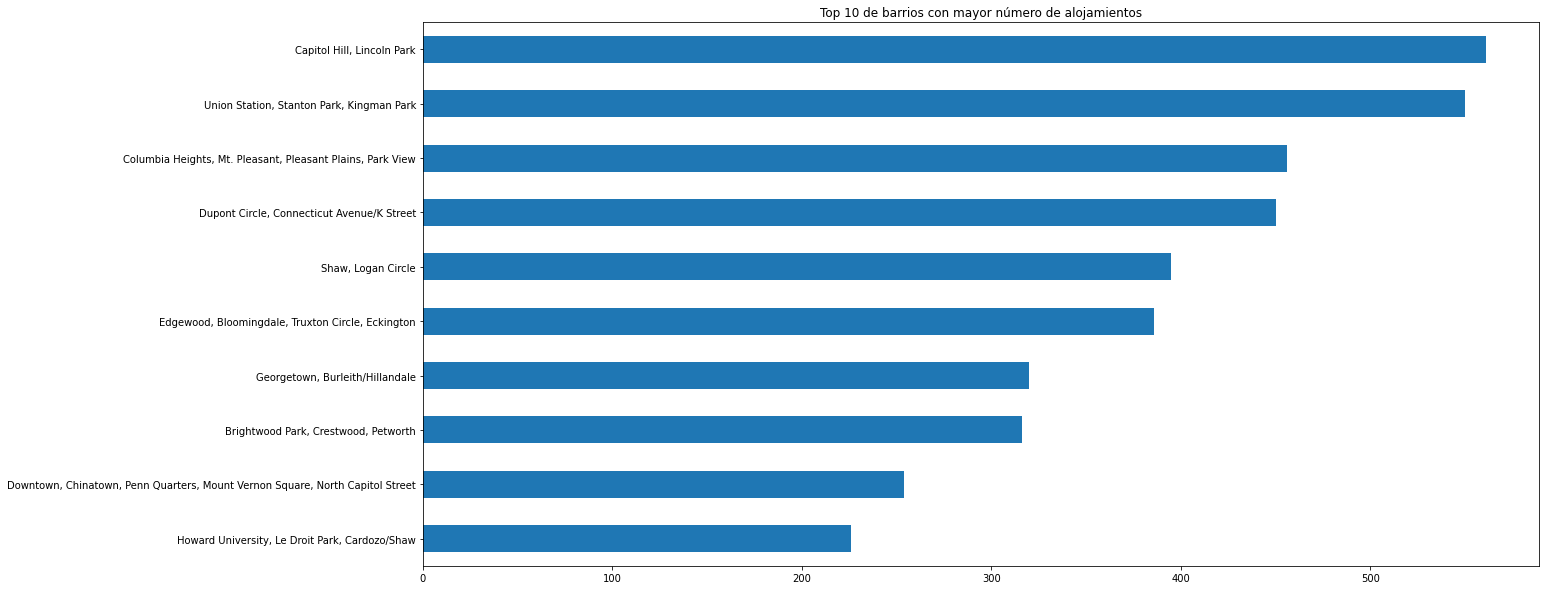

In [16]:
print("Número de barrios únicos")
print(len(datos.neighbourhood_cleansed.unique()))
#print(datos.neighbourhood_cleansed.unique())

# mostramos el top 10
datos['neighbourhood_cleansed'].value_counts().head(10).sort_values().plot(kind='barh', figsize=(20,10), title="Top 10 de barrios con mayor número de alojamientos")

Graficamos algunas características como el número de guests, baños y camas junto con el precio:

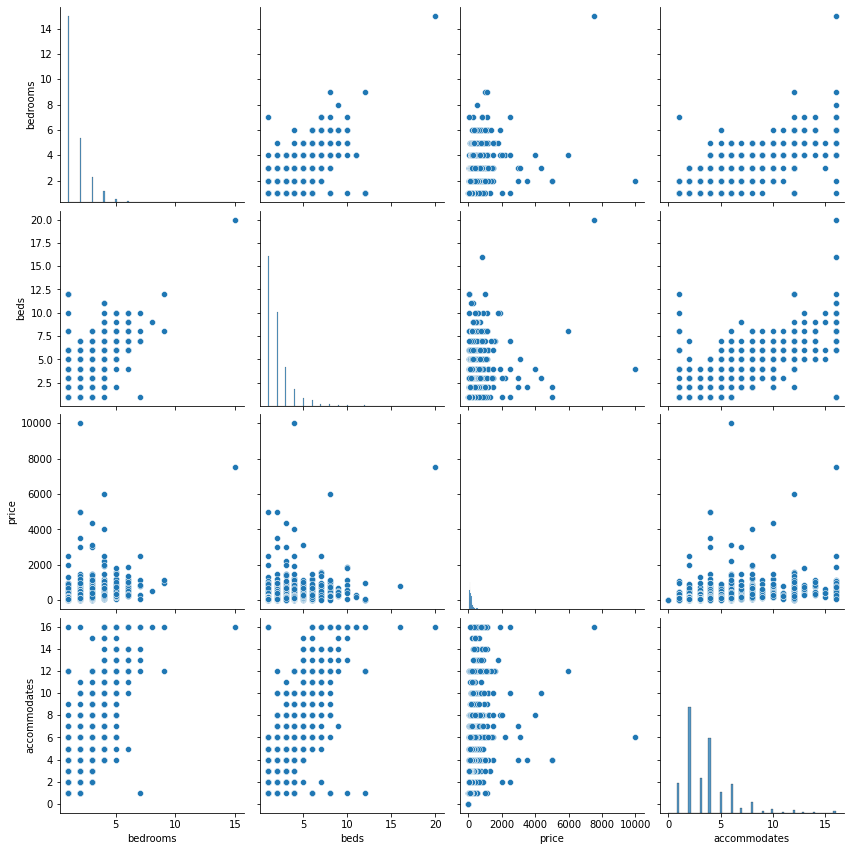

In [18]:
variables = ['bedrooms', 'beds', 'price','accommodates']
sns.pairplot(datos[variables], height=3)

Top 10 de hosts con el mayor número de alojamientos:

Text(0, 0.5, 'Número de alojamientos')

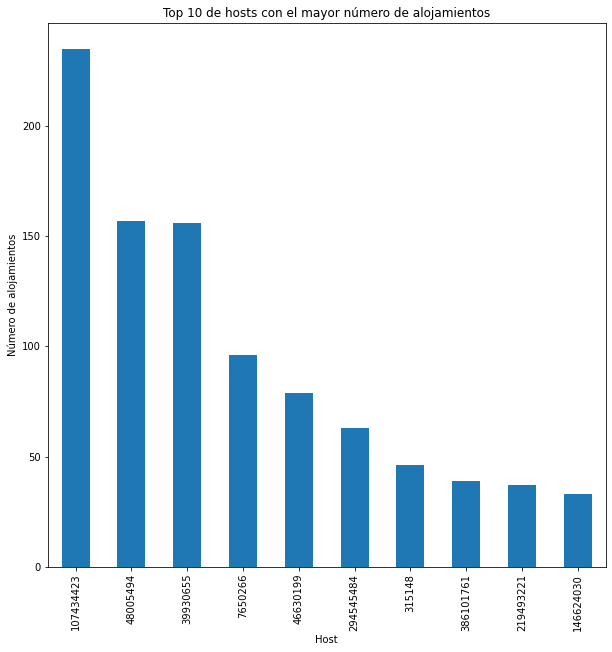

In [19]:
plt.figure(figsize=(10,10))
top10_hosts = datos['host_id'].value_counts().head(10)
tmp = top10_hosts.plot(kind='bar')
tmp.set_title('Top 10 de hosts con el mayor número de alojamientos')
tmp.set_xlabel('Host')
tmp.set_ylabel('Número de alojamientos')

Distribución de los tipos de habitación:

[Text(0.5, 1.0, 'Número de alojamientos por tipo de habitación')]

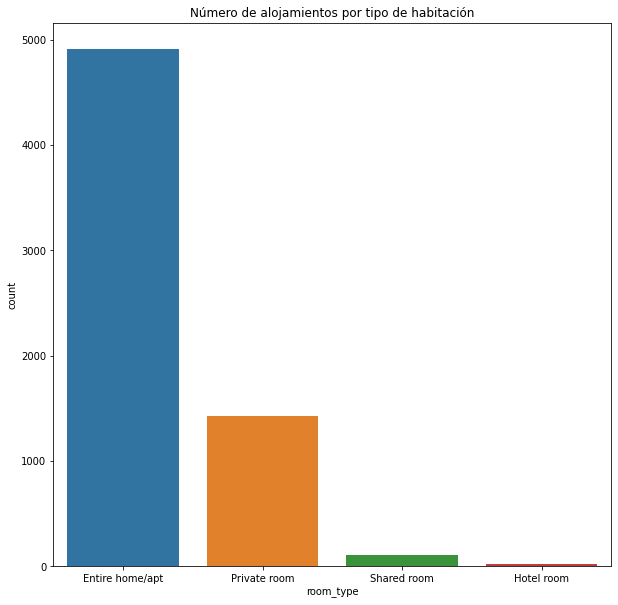

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(x="room_type", data=datos, order = datos['room_type'].value_counts().index).set(title="Número de alojamientos por tipo de habitación")

Generamos y exportamos el archivo para poder usarlo en las hojas de cálculo de google

In [21]:
# Generamos y exportamos el archivo para poder usarlo en las hojas de cálculo de google
#with open('ListingsAirbnbKaren.csv', 'w') as f:
#  datos.to_csv(f,  index = False)
#files.download('ListingsAirbnbKaren.csv')